# [튜토리얼3] 시계열 데이터 예측하기

이번 튜토리얼에서는 순환 신경망 **RNN(Recurrent Neural Networks)** 을 사용한 시계열 데이터인 날씨 데이터 예측을 진행해볼 것입니다. 

다음과 같이 두 섹션으로 나누어져 진행됩니다. 

1. `일변량` 시계열 예측
2. `다변량` 시계열 예측

In [1]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# 목차
1. 날씨 데이터셋
2. Part 1: 일변량 시계열 예측하기
    - 2.1 베이스라인(baseline)
    - 2.2 순환신경망(RNN)
        - 간단한 LSTM 모델을 사용해서 예측하기
3. Part 2: 다변량 시계열 예측하기
    - 3.1 단일 스텝 모델
        - 단일 스텝 미래 예측하기
    - 3.2 멀티 스텝 모델
        - 멀티 스텝 미래 예측하기

## 1. 날씨 데이터셋
시계열 데이터셋은 [Max Plank Institute for BioGeochemistry](https://www.bgc-jena.mpg.de)에서 기록한 [날씨 시계열 데이터셋](https://www.bgc-jena.mpg.de/wetter/)을 사용합니다.

이 데이터셋에는 공기 온도, 대기 압력, 습도 등 **14가지**의 피쳐가 포함되어 있습니다. 이들은 2003년부터 10분마다 수집되었고, 효율을 위해 2009년에서 2016년 사이에 수집된 데이터 중 100,000 개의 데이터만을 사용하겠습니다. 데이터셋은 프랑수아 콜렛의 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)에서 미리 전처리된 것을 사용하겠습니다.

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [3]:
df = pd.read_csv(csv_path)

# 100,000개 데이터 사용
df = df.iloc[:100000]

데이터를 살펴봅시다.

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


`Date Time` 피쳐에서 확인할 수 있듯이 10분마다 관측치가 기록됩니다. 즉, 한 시간 동안 6개의 관측치를 갖게 됩니다. 마찬가지로, 하루에 총 144개(6x24)의 관측치가 있습니다.

만약 특정 시간대에서 6시간 동안 온도를 예측하고 싶다고 가정해 보겠습니다. 이 예측을 하기위해 5일 동안의 관측치를 사용하도록 선택합니다. 따라서 마지막 720개(하루 144개x5일)의 관측치가 포함된 창(window)을 만들어 모델을 학습시킵니다.

아래 기능은 모델에 대해 위에서 설명한 시간 창(window)을 반환합니다. `history_size` 매개변수는 과거 정보에 대한 창의 크기입니다. `target_size`는 모델이 예측하는 법을 배워야 할 미래의 범위입니다.

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # 데이터의 형태를 (history_size,)에서 (history_size, 1)로 변환합니다.
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

다음 두 가지 튜토리얼에서 첫 번째 9만 행의 데이터는 학습 데이터셋, 남은 데이터는 검증 데이터셋으로 나눕니다. 이는 최대 625일 분량의 학습 데이터에 해당합니다.

In [6]:
TRAIN_SPLIT = 90000

시드를 설정하여 동일한 결과를 가질 수 있도록 재현성을 보장합니다.

In [7]:
tf.random.set_seed(13)

## 2. Part 1: 일변량 시계열 예측하기

먼저 단일 피쳐(온도)만 사용하여 모델을 학습시키고, 이를 사용하여 향후 해당 값을 예측합니다.

먼저 데이터셋에서 온도만 추출해 보겠습니다.

In [8]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

시간이 지남에 따라 이 데이터가 어떻게 변하는지 관찰해 보겠습니다.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48aa7aaa58>],
      dtype=object)

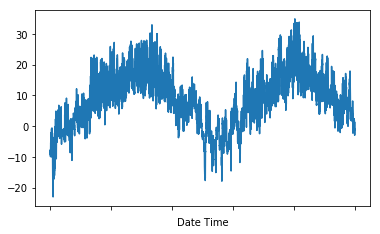

In [9]:
uni_data.plot(subplots=True)

In [10]:
uni_data = uni_data.values

신경망을 학습시키기 전에 피쳐의 크기를 조정하는 것이 중요합니다. 평균을 빼고 각 피쳐의 표준 편차로 나누어 스케일링하는 것이 일반적인 표준화 방법입니다. 또는 값을 [0.1]의 범위로 다시 정렬하는 `tf.keras.utils.normalize` 메소드를 사용할 수도 있습니다.

여기서는 일반적인 표준화 방법을 사용하여 피쳐의 크기를 조정하도록 하겠습니다.

- 참고: 평균 및 표준 편차는 학습 데이터를 사용하여 계산해야 합니다.

In [11]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

데이터를 표준화합시다.

In [12]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

이제 일변량 모형에 대한 데이터를 생성하겠습니다. 

일변량 시계열을 예측하는 part 1의 경우 마지막으로 기록된 온도 관측치 20개가 모델에 주어지고 다음 스텝에서 온도를 예측하는 방법을 학습해야 합니다.

In [13]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

이것이 `univariate_data` 함수가 반환하는 것입니다.

In [52]:
print ('마지막으로 기록된 온도 관측치 20개')
print (x_train_uni[0])
print ('\n 예측해야 하는 타겟 온도')
print (y_train_uni[0])

마지막으로 기록된 온도 관측치 20개
[[-1.89329341]
 [-1.93666302]
 [-1.94778344]
 [-1.92554261]
 [-1.92109445]
 [-1.89662954]
 [-1.84881176]
 [-1.84881176]
 [-1.88106096]
 [-1.93888711]
 [-1.97558447]
 [-1.98892897]
 [-1.98559284]
 [-1.98336876]
 [-1.96446406]
 [-1.96446406]
 [-1.96891222]
 [-1.98114468]
 [-1.9844808 ]
 [-1.99560121]]

 예측해야 하는 타겟 온도
-1.9956012130997496


이제 데이터가 생성되었으니,예시 샘플을 살펴보겠습니다. 신경망에 부여된 정보는 파란색으로 제공되며, 빨간색 X로 표시된 값을 예측해야 합니다.

In [15]:
def create_time_steps(length):
    return list(range(-length, 0))

In [16]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

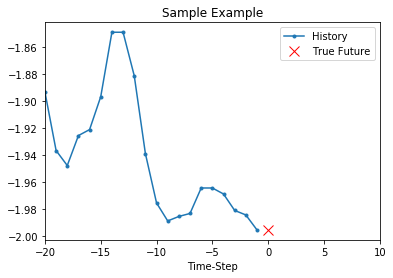

In [17]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### 2.1 베이스라인(baseline)
모델을 학습시키기 전에 먼저 간단한 기준선을 설정하겠습니다. 입력 포인트를 지정하면 베이스라인 메소드는 모든 기록을 검토하고 다음 포인트를 최근 20개 관측치의 평균으로 예측합니다.

In [18]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

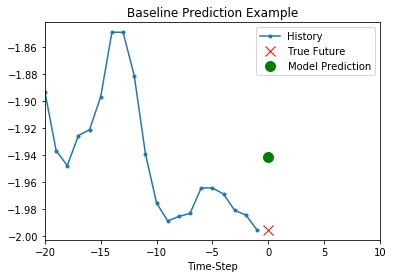

In [19]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

순환 신경망을 이용해서 이 기준선을 넘을 수 있는지 확인해보겠습니다.

### 2.2 순환신경망(RNN)
순환신경망(Recurrent Neural Network, RNN)은 시계열 데이터에 적합한 신경망의 한 종류입니다. RNN은 시계열을 단계별로 처리하여 지금까지 본 정보를 요약한 내부 상태를 유지합니다.

이제 `tf.data`를 사용하여 데이터셋을 섞고 배치하며 캐싱하겠습니다.

In [20]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

다음 시각화는 배치(batch) 후 데이터가 어떻게 표시되는지 이해하는 데 도움이 됩니다.

![Time Series](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/time_series.png?raw=1)

LSTM에는 주어진 데이터의 입력 형태(shpae)가 필요합니다.

In [21]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

샘플 예측을 통해 모델의 출력을 점검해 보겠습니다.

In [22]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


이제 모델을 학습시킵니다. 데이터셋의 크기가 크기 때문에 시간 절약을 위해 각 에포크는 전체 학습 데이터가 아닌 200스텝에서만 실행됩니다.

In [23]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 23ms/step - loss: 0.3797 - val_loss: 0.1305
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1067 - val_loss: 0.0316
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0473 - val_loss: 0.0270
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0429 - val_loss: 0.0257
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0329 - val_loss: 0.0245
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0328 - val_loss: 0.0217
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0275 - val_loss: 0.0203
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0257 - val_loss: 0.0190
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0248 - val_loss: 0.0178
Epoch 10/10
200/200 [===========================

#### - 간단한 LSTM 모델을 사용해서 예측하기
이제 간단한 LSTM을 학습시켰으니 몇 가지 예측을 해보도록 하겠습니다.

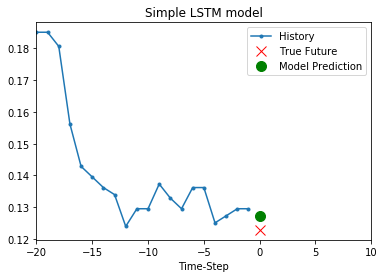

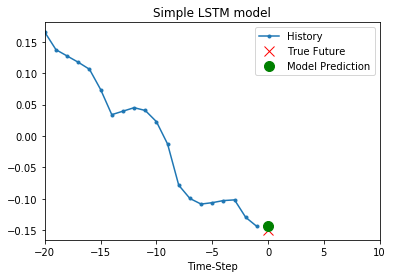

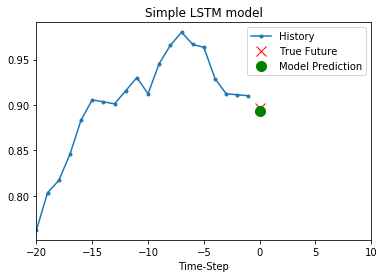

In [24]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

이게 베이스라인보다 더 나아 보이네요. 이제 기본을 살펴보았으니 2부로 넘어가 보겠습니다. part 2에서는 다변량 시계열로 작업할 것입니다.

## 3. Part 2: 다변량 시계열 예측하기

원 데이터셋에는 14개의 피쳐가 있으나 단순성을 위해 14개의 피쳐 중 3개만 고려합니다. 사용되는 피쳐는 공기 온도(p (mbar)), 대기 압력(T (degC)) 및 공기 밀도(rho (g/m**3))입니다.

더 많은 피쳐를 사용하려면 해당 피쳐 이름을 아래 `features_considered` 리스트에 추가하면 됩니다.

In [25]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [26]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


각 피쳐가 시간에 따라 어떻게 달라지는지 살펴보겠습니다

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48087b1c50>,
      dtype=object)

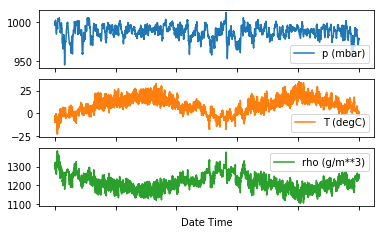

In [27]:
features.plot(subplots=True)

앞서 언급한 바와 같이 첫 번째 단계는 학습 데이터의 평균과 표준 편차를 사용하여 데이터셋을 표준화하는 것입니다.

In [28]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [29]:
dataset = (dataset-data_mean)/data_std

### 3.1 단일 스텝 모델
단일 스텝 모델은 주어진 일부 기록을 기반으로 미래의 **단일 포인트를 예측**하는 방법을 학습합니다.

아래 함수는 위의 `univariate_data` 함수와 같이 창(window) 설정 작업을 수행하지만, 여기서는 주어진 스텝 크기에 따라 과거 관측치를 샘플링합니다.

In [30]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

이번 튜토리얼에서는 지난 5일 동안의 데이터, 즉 총 720개의 관측치가 표시됩니다. 60분 이내에 급격한 변화가 예상되지 않기 때문에 1시간마다 관측치가 기록되고, 따라서 120개(하루 24개 * 5일)의 관측치는 지난 5일의 기록을 나타냅니다. 단일 스텝 예측 모델의 경우 예측해야 하는 데이터 포인트의 레이블은 이후 12시간 동안의 온도입니다. 이에 대한 레이블로 관측치 이후 72(12 * 6)개의 온도가 사용됩니다.

In [31]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

하나의 데이터 포인트를 살펴봅시다.


In [32]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [33]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [34]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

샘플 예측을 확인해봅시다.

In [35]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [36]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 20s 100ms/step - loss: 0.2939 - val_loss: 0.2638
Epoch 2/10
200/200 [==============================] - 18s 88ms/step - loss: 0.2497 - val_loss: 0.2614
Epoch 3/10
200/200 [==============================] - 17s 87ms/step - loss: 0.2399 - val_loss: 0.2594
Epoch 4/10
200/200 [==============================] - 18s 88ms/step - loss: 0.2305 - val_loss: 0.2723
Epoch 5/10
200/200 [==============================] - 18s 88ms/step - loss: 0.2293 - val_loss: 0.2652
Epoch 6/10
200/200 [==============================] - 18s 88ms/step - loss: 0.2235 - val_loss: 0.2619
Epoch 7/10
200/200 [==============================] - 18s 88ms/step - loss: 0.2209 - val_loss: 0.2581
Epoch 8/10
200/200 [==============================] - 17s 87ms/step - loss: 0.2202 - val_loss: 0.2723
Epoch 9/10
200/200 [==============================] - 17s 87ms/step - loss: 0.2169 - val_loss: 0.2695
Epoch 10/10
200/200 [=================

In [37]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

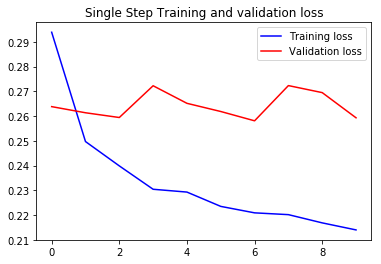

In [38]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### - 단일 스텝 미래 예측하기
이제 모델이 학습되었으니 몇 가지 예시를 살펴보겠습니다. 모델은 지난 5일 동안 매 시간(120개의 데이터 포인트)마다 세 가지 피쳐에 대한 기록을 입력받습니다. 목표는 온도를 예측하는 것이므로 그림은 과거 온도에 대해서만 표시합니다. 예측은 미래(기록와 예측의 차이를 확인)의 하루 동안의 예측입니다.

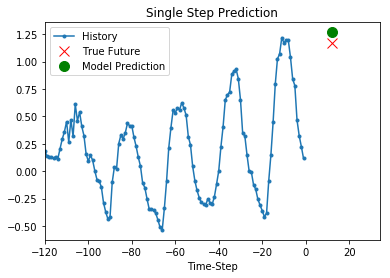

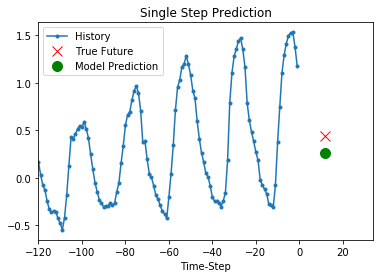

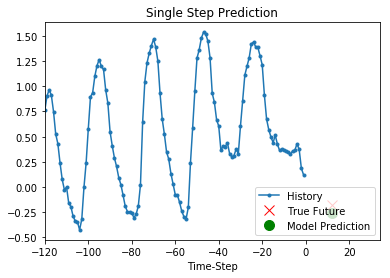

In [39]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

### 3.2 멀티 스텝 모델
멀티 스텝 예측 모델은 과거 기록을 가지고 미래의 **다양한 값을 예측**하는 방법을 학습합니다. 따라서 하나의 미래만 예측되는 단일 스텝 모델과 달리, 멀티 스텝 모델은 미래의 시퀀스(sequence)를 예측합니다.

멀티 스텝 모델의 경우 학습 데이터는 다시 매 시간마다 샘플링된 지난 5일 동안의 기록으로 구성됩니다. 하지만 여기서 모델은 이후 12시간 동안의 온도를 예측하는 방법을 배워야 합니다. 따라서 관측은 10분마다 기록되므로 출력은 72개의 예측값입니다. 이 작업을 수행하려면 데이터셋을 그에 따라 준비해야 하므로 첫 번째 단계에서는 데이터셋을 다시 생성해보도록 하겠습니다. 하지만 다른 타겟 창을 사용합니다.

In [40]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

샘플 데이터 포인트를 확인해봅시다.

In [53]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

Target temperature to predict : (72,)


In [42]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

샘플 데이터 포인트를 그려봅시다.

In [43]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

이 그림과 아래의 비슷한 그림에서는 기록과 미래 데이터가 매 시간마다 샘플링됩니다.

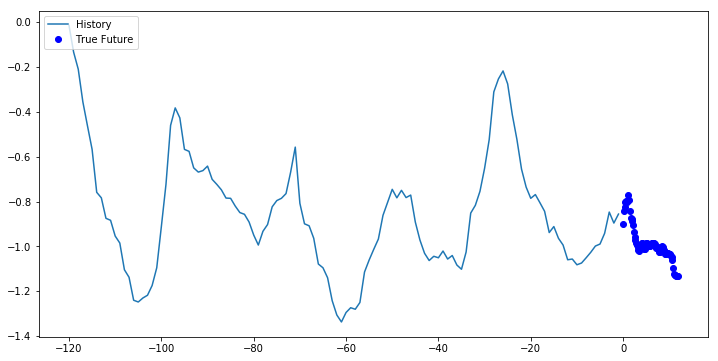

In [44]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

여기서의 작업은 이전 작업보다 약간 더 복잡하기 때문에 이제 모델은 두 개의 LSTM 레이어로 구성됩니다. 마지막으로 72개의 예측이 이루어지기 때문에 dense 레이어는 72개의 예측을 출력합니다.

In [45]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

모델이 학습하기 전에는 어떻게 예측하는지 살펴봅시다.

In [46]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [47]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 36s 181ms/step - loss: 0.6748 - val_loss: 0.3035
Epoch 2/10
200/200 [==============================] - 32s 162ms/step - loss: 0.3487 - val_loss: 0.2993
Epoch 3/10
200/200 [==============================] - 33s 163ms/step - loss: 0.3257 - val_loss: 0.2653
Epoch 4/10
200/200 [==============================] - 32s 162ms/step - loss: 0.2554 - val_loss: 0.2293
Epoch 5/10
200/200 [==============================] - 32s 162ms/step - loss: 0.2153 - val_loss: 0.2217
Epoch 6/10
200/200 [==============================] - 32s 161ms/step - loss: 0.2031 - val_loss: 0.2022
Epoch 7/10
200/200 [==============================] - 32s 162ms/step - loss: 0.1930 - val_loss: 0.1991
Epoch 8/10
200/200 [==============================] - 32s 162ms/step - loss: 0.1879 - val_loss: 0.1973
Epoch 9/10
200/200 [==============================] - 32s 161ms/step - loss: 0.1835 - val_loss: 0.2030
Epoch 10/10
200/200 [=========

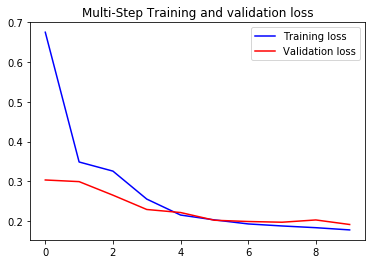

In [48]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### - 멀티 스텝 미래 예측하기
이제 신경망이 미래를 예측하는 방법을 얼마나 잘 학습했는지 시각화를 통해 살펴보겠습니다.

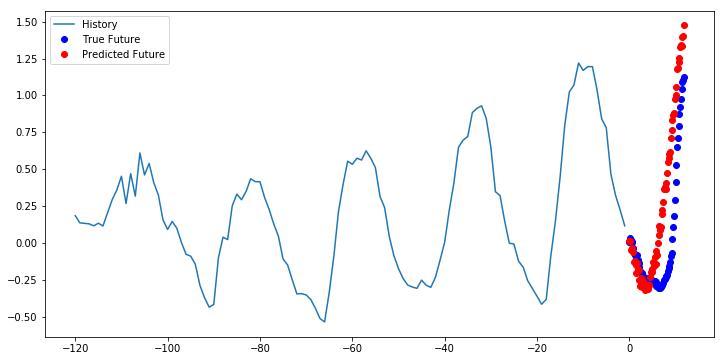

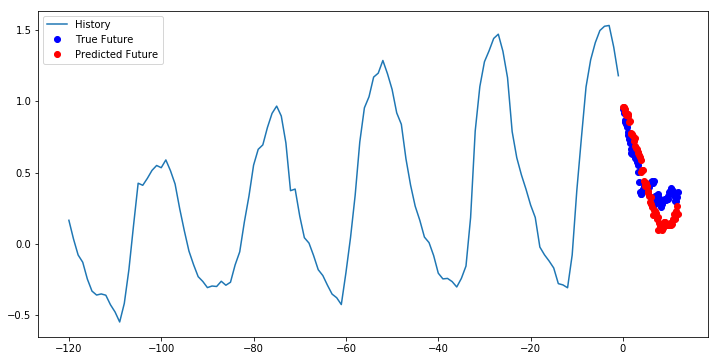

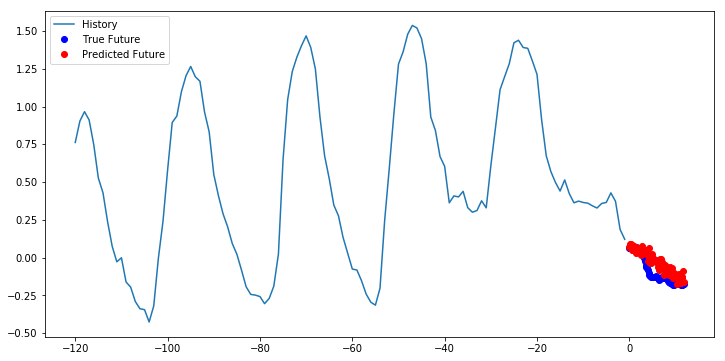

In [49]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# Copyright 2019 The TensorFlow Authors.

In [50]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.